In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import softmax
from scipy.spatial.distance import euclidean,cosine
import biomart


import umap
import pickle
import scipy.spatial as sp
import seaborn as sns
import itertools

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

from scipy.spatial.distance import pdist,squareform
from scipy.cluster import hierarchy

from numpy.linalg import eig
from sklearn.cluster import KMeans

import glob
import scanpy as sc
sc.settings.set_figure_params(dpi=200)

# Visualizations

In [2]:
class Visualizations(object):
    def plot_pca_trajs(ax,patterns,resolvers,highlight_idx=[]):
        pca = PCA(n_components=2)
        pca.fit(patterns)
        pca_data = pca.transform(patterns)
        ax.scatter(pca_data[:,0],pca_data[:,1],c='gray',s=20)
        for i,resolver in enumerate(resolvers):
            pca_traj = pca.transform(resolver.resolved_array)
            if i in highlight_idx:
                ax.plot(pca_traj[:,0],pca_traj[:,1],lw=3,c='r')
            else:
                ax.plot(pca_traj[:,0],pca_traj[:,1],lw=1,c='k')
        ax.grid(False)
        ax.set_facecolor('white')
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_yticks([])
        ax.set_xticks([])
        
        
    def label_heatmap_annealing(ax,arr):
        N,K = arr.shape
        ax.set_yticks(range(K))
        ax.set_xticks([0.01*N,N*.3,N*.6,N*.9])
        ax.set_xticklabels([r'high $\beta$',r'low $\beta$',r'med. $\beta$',r'high $\beta$'],rotation=90)
        ax.set_yticks(np.arange(-.5,K+.5),minor=True)
        ax.set_yticklabels([(i+1) for i in range(K)])
        
        
    def plot_enhancer_probs(ax,resolver,aspect=.5,label_annealing=True,cbar=False,vmax=0):
        enhancer_probs = np.array([(np.exp(beta*np.matmul(resolver.patterns,traj))/np.exp(beta*np.matmul(resolver.patterns,traj)).sum()) for traj,beta in zip(resolver.resolved_array,resolver.beta_vals)])

        cax=ax.imshow(enhancer_probs.T,aspect=aspect*enhancer_probs.shape[0]/enhancer_probs.shape[1],vmin=0,vmax=1,cmap="Greens")
        
        if vmax==0:
            vmax=enhancer_probs.max()
        
        if label_annealing:
            Visualizations.label_heatmap_annealing(ax,enhancer_probs)
        else:
            ax.set_yticks(np.arange(-.5,resolver.patterns.shape[0]+.5),minor=True)
            ticks=np.arange(0,resolver.resolved_array.shape[0]-1,100)
            ax.set_xticks(ticks)
            ax.set_xticklabels([int(np.round(x)) for x in resolver.t[ticks]])
        ax.grid(visible=True, which='major', color='gray',lw=0)
        ax.grid(visible=True, which='minor', color='gray',lw=1)
        ax.set_ylabel('enhancer')
        if cbar:
            plt.colorbar(ax=ax,mappable=cax)
        
    def plot_tf_levels(ax,resolver,aspect=.5,label_annealing=True,cbar=False,vmax=0):
        if vmax==0:
            vmax=resolver.patterns.max()
        cax=ax.imshow(resolver.resolved_array.T,aspect=aspect*resolver.resolved_array.shape[0]/resolver.resolved_array.shape[1],
                  vmin=0,vmax=vmax,cmap="Greens")
        
        if label_annealing:
            Visualizations.label_heatmap_annealing(ax,resolver.resolved_array)
        else:
            ax.set_yticks(np.arange(-.5,resolver.patterns.shape[1]+.5),minor=True)
            ticks=np.arange(0,resolver.resolved_array.shape[0]-1,100)
            ax.set_xticks(ticks)
            ax.set_xticklabels([int(np.round(x)) for x in resolver.t[ticks]])
        ax.grid(visible=True, which='major', color='gray',lw=0)
        ax.grid(visible=True, which='minor', color='gray',lw=1)
        ax.set_ylabel('TF')
        if cbar:
            plt.colorbar(ax=ax,mappable=cax)
            
    def umap_plot_diff_trajs(ax,resolvers,verbose=True):
        umap_patterns=[]
        for resolver in resolvers:
            umap_patterns.append(resolver.resolved_array[5::5])

        ln=len(umap_patterns[-1])
        umap_patterns = np.concatenate(umap_patterns)

        ft = umap.UMAP(n_neighbors=15).fit_transform(umap_patterns)

        colors = ['red','green','purple','blue','gold','gray','orange','#1f77b4', '#8c564b','#e377c2','#17becf']

        used_names = np.array([])

        for idx,resolver in zip(np.arange(0,ft.shape[0],ln),resolvers):
            name = resolver.tag
            
            if not name in used_names:
                if verbose:
                    ax.text(ft[idx+ln-1,0]-3,ft[idx+ln-1,1]+.5,name,fontsize=20)
                used_names = np.append(used_names,name)
            id_=np.argwhere(used_names==name)[0,0]
            ax.scatter(ft[idx:idx+ln,0],ft[idx:idx+ln,1],c=colors[id_])
            ax.plot(ft[idx:idx+ln,0],ft[idx:idx+ln,1],c=colors[id_],lw=.1)

        ax.set_xlabel("UMAP 1")    
        ax.set_ylabel("UMAP 2")    
        ax.grid(False)
        ax.set_facecolor('white')
        
    def plot_patterns(ax,patterns,aspect=.5):
        K,N=patterns.shape
        ax.imshow(patterns.max()-patterns.T,aspect=aspect*patterns.shape[0]/patterns.shape[1],
                  cmap='gray',vmin=0,vmax=patterns.max())
        ax.set_yticks(range(N))
        ax.set_xticks(range(K))
        ax.set_yticks(np.arange(-.5,N+.5),minor=True)
        ax.set_xticks(np.arange(-.5,K+.5),minor=True)
        ax.grid(visible=True, which='major', color='gray',lw=0)
        ax.grid(visible=True, which='minor', color='gray',lw=1)
        ax.set_xticklabels(['EN%d'%(i+1) for i in range(K)],rotation=90)
        ax.set_yticklabels(['TF%d'%(i+1) for i in range(N)],rotation=0)

    def plot_heatmap_dendrogram(enhancer_net,ax_heatmap,ax_dendrogram):
        def est_dendrogram(ax,enhancer_net):
            ydist = pdist(enhancer_net.patterns,metric='cosine')
            dist_mat = pd.DataFrame(squareform(ydist), index=enhancer_net.names, columns= enhancer_net.names)

            Z = hierarchy.linkage(100*ydist, 'average')
            dn = hierarchy.dendrogram(Z,labels=enhancer_net.names,
                                      orientation='left',leaf_rotation=0,
                                      color_threshold=0,above_threshold_color='k',
                                      leaf_font_size=0,ax=ax,show_leaf_counts=True)
            ax.set_yticks([])
            ax.set_xticks([])
            hierarchy.set_link_color_palette(None) 

            ax.grid(False)
            ax.set_facecolor('white')
            return dist_mat,dn['ivl']

        dist_mat,order = est_dendrogram(ax_dendrogram,enhancer_net)

        sns.set(font_scale=1.4)
        cg=sns.heatmap(dist_mat.loc[order[::-1],order[::-1]],annot_kws={"size": 30},cmap='crest',
                      cbar_kws=dict(orientation='vertical',location='right'),ax=ax_heatmap)
        ax_heatmap.set_xlabel("")
        ax_heatmap.set_ylabel("")
        ax_heatmap.collections[0].colorbar.set_label(r'$1-\cos{\theta}$')



# Resolvers

In [24]:
class Resolver(object):
    def __init__(self,ximat,w=None,qmat=None):
        self.patterns = ximat.copy()
        if type(qmat)==type(None):
            qmat = self.patterns
        if type(w)==type(None):
            w=np.zeros(self.patterns.shape[0])
        self.qmat = qmat
        self.w = w
    def euler_step(self,x,beta,w,x_prod,sigma=0,dt=.1):
        det_dx = x_prod + np.matmul(self.qmat.T,softmax(w + beta*np.matmul(self.patterns,x))) - x
        if sigma>0:
            noise_dx = sigma*np.random.normal(size=x.shape[0])
        else:
            noise_dx = 0
            
        return dt*(det_dx)+np.sqrt(dt)*noise_dx
    
    def resolve(self,x0,tmax,beta_func,sigma=0,x_prod_func = None,dt=.1):
        """
        resolve initializes the values of resolved_array,beta_vals,and t after resolution by iteration
        """
        self.t = np.arange(0,tmax,dt)
        self.beta_vals = np.array([beta_func(t) for t in self.t])
        self.resolved_array = np.zeros([self.t.shape[0],len(x0)])
        
        if type(x_prod_func)==type(None):
            null_prod = np.zeros(x0.shape[0])
            x_prod_func = lambda t: null_prod
        x = x0.copy()
        for i,t in enumerate(self.t):
            self.resolved_array[i,:]=x.copy()
            x += self.euler_step(x,beta_func(t),self.w,x_prod_func(t),sigma,dt)
        return x,t,self.beta_vals,self.resolved_array
    
    def tag(self,tag):
        self.tag = tag
        
    def jacobian(self,beta,x):
        def est_jac_idx(j,k):
            activation_vec = np.exp(self.w + beta*np.dot(self.patterns,x))
            Z = activation_vec.sum()
            jac_A = beta * ((activation_vec*self.qmat[:,j]*self.patterns[:,k]).sum()/Z - (activation_vec*self.qmat[:,j]).sum()*(activation_vec*self.patterns[:,k]).sum() / (np.power(Z,2)))
            if not j==k:
                return jac_A
            else:
                return jac_A - 1
        jac = np.zeros((self.patterns.shape[1],self.patterns.shape[1]))
        for j in range(jac.shape[0]):
            for k in range(jac.shape[1]):
                jac[j,k] = est_jac_idx(j,k)
        return jac
    

class TFProcess(object):
    def initialize_patterns(df):
        patterns = (df.copy().values)
        norm_ = np.linalg.norm(patterns,axis=1)
        patterns = np.array([patterns[i]/norm_[i] for i in range(patterns.shape[0])])

        return patterns,list(df.index),list(df.columns)
    
    def __init__(self,df,w):
        if type(w)==type(None):
            w=np.zeros(df.shape[0])
        self.w = w
        self.patterns,self.names,self.TFs = TFProcess.initialize_patterns(df)
        
    def most_similar_x(self,res):
        dists=[euclidean(pattern,res) for pattern in self.patterns]
        dists_cosine=[cosine(pattern,res) for pattern in self.patterns]
        return self.names[np.argmin(dists)],np.min(dists_cosine)
    
    def avg_state(self):
        return self.patterns.mean(axis=0)

class TFProcessStaticBeta(TFProcess):
    def __init__(self,df,w=None,beta=100):
        self.beta = beta
        TFProcess.__init__(self,df,w)
        
   
    def generate_noisy_condition_sim(self,name,
                                             binding_noise_mag = 0,
                                             initial_conditions_noise_mag = 0.2,
                                             duration=30):
        resolver = Resolver(self.patterns,self.w)
        idx = np.argwhere([x==name for x in self.names])[0,0]
        
        x0=self.patterns[idx]*np.random.normal(1,initial_conditions_noise_mag,self.patterns.shape[1])
        x0[x0<0]=0
        resolver.patterns = resolver.patterns*(np.random.normal(loc=1.0,scale=binding_noise_mag,size=resolver.patterns.shape))
        resolver.patterns[resolver.patterns<0]=0
        norm_ = np.linalg.norm(resolver.patterns,axis=1)
        resolver.patterns = np.array([resolver.patterns[i]/norm_[i] for i in range(resolver.patterns.shape[0])])
        
        x,t,_,resolved_array = resolver.resolve(x0,duration,lambda t: self.beta)
        tag,dist=self.most_similar_x(resolved_array[-1])
        return tag,dist,resolver
        
    def reprogram(self,init_cell,factors,strengths,pulse_width=10,sigma=0):
        resolver = Resolver(self.patterns,self.w)
        
        activation_vec_orig = pd.Series(np.zeros(len(enhancer_net.TFs)),enhancer_net.TFs)
        activation_vec_mod = activation_vec_orig.copy()
        activation_vec_mod[factors] = strengths
        x0 = self.patterns[np.argwhere(np.array(self.names)==init_cell)[0,0]]
        def x_prod_func(t):
            if t<pulse_width:
                return activation_vec_orig
            elif t<2*pulse_width:
                return activation_vec_mod
            else:
                return activation_vec_orig
        resolver.resolve(x0,3*pulse_width,lambda t: self.beta,x_prod_func=x_prod_func,sigma=sigma)
        resolver.tag(self.most_similar_x(resolver.resolved_array[-1])[0])
        return resolver,activation_vec_mod
    
    def process_reprogramming_input(self,reprog_paths,verbose=True):
        resolvers = []
        for i in range(reprog_paths.shape[0]):
            resolver,_ = self.reprogram(reprog_paths.iloc[i].loc["source cell"],reprog_paths.iloc[i]["factors"].split(","),[float(x) for x in reprog_paths.iloc[i].loc["weights"].split(",")])
            resolvers.append(resolver)
            if verbose:
                print("PREDICTION/RESULT: ",reprog_paths.iloc[i].loc["target cell"],"/",resolver.tag)
        return resolvers
    
    def generate_noised_input_trajectories(self,assert_same=True,binding_noise_mag=0,initial_conditions_noise_mag=0.2):
        resolvers = []
        frac_same= []
        dists=[]
        for name in self.names:
            target,dist,resolver = self.generate_noisy_condition_sim(name,binding_noise_mag,initial_conditions_noise_mag)
            if assert_same:
                assert(name==target)
            resolvers.append(resolver)
            frac_same.append(name==target)
            dists.append(dist)
        return resolvers,np.array(frac_same),np.array(dists)
    
class TFProcessAnnealing(TFProcess):
    def __init__(self,df,w=None,sigma=0,beta_max=5,frac_init=0.1):
        self.frac_init = frac_init
        self.beta_max = beta_max
        self.sigma=sigma
        TFProcess.__init__(self,df,w)
        
    def annealing(self,x0,tmax=100):
        resolver = Resolver(self.patterns,self.w)
        
        tinit=tmax*self.frac_init
        tgap = tmax-tinit
        betafunc = lambda t: self.beta_max if t < tinit else .01 + self.beta_max*(t-tinit)/tgap
        
        resolver.resolve(x0,tmax,betafunc,sigma=self.sigma)
        resolver.tag(self.most_similar_x(resolver.resolved_array[-1])[0])
        return resolver
    
    def adj_w_balanced_diff(self,max_iter=1000):
        x0=self.avg_state()
        w=pd.Series(np.zeros(self.patterns.shape[0]),index=self.names)
        hist_=[]
        for iter_ in range(max_iter):
            self.w=w.values
            resolver = self.annealing(x0)
            j = self.most_similar_x(resolver.resolved_array[-1])[0]
            w[j]-=.5*(1-iter_/max_iter)
            w=w-w.mean()
        self.w=w

    def produce_differentiation_trajectories(self,traj_output_number=20,max_iter_=1000,verbose=True):
        hist=np.array([])
        resolvers=[]
        for iter_ in range(max_iter_):
            resolver=self.annealing(self.avg_state())
            hist = np.append(hist,resolver.tag)
            if (hist==resolver.tag).sum()<traj_output_number+1:
                resolvers.append(resolver)
            
        return resolvers


class Genome(object):
    """
    The Genome object is an object that contains an explicit representaiton of all enhancers and associations in a genome
    each enhancer binds one of N tfs, indexed 1,...,N
    """
    def __init__(self):
        self.xi_mat = None
        self.q_mat_T = None
        self.enhancer_ids = []
    def add_enhancer(self,tf_binding_dict,q_association_dict,normalize=False,eid=-1):
        """
        TF binding dict = format {TF : XI_TF}
        Q binding dict = format {TF : Q_TF}
        """
        xi_vec = np.zeros(self.N)
        q_vec = np.zeros(self.N)
        for tf in tf_binding_dict.keys():
            xi_vec[tf] = tf_binding_dict[tf]
        for tf in q_association_dict.keys(): 
            q_vec[tf]  = q_association_dict[tf]
            
        if normalize:
            xi_vec = xi_vec /np.linalg.norm(xi_vec)
        
        if type(self.xi_mat)==type(None):
            self.xi_mat = xi_vec.reshape(1,self.N)
        else:
            self.xi_mat = np.append(self.xi_mat,xi_vec.reshape(1,self.N),axis=0)
        if type(self.q_mat_T)==type(None):
            self.q_mat_T = q_vec.reshape(self.N,1)
        else:
            self.q_mat_T = np.append(self.q_mat_T,q_vec.reshape(self.N,1),axis=1)
            
        self.enhancer_ids.append(eid)
            
    def run_x0(self,x0,tmax=10,beta=50,w=None):
        resolver = Resolver(ximat=self.xi_mat,qmat=self.q_mat_T.T)
        resolver.resolve(x0,tmax,lambda t: beta)
        
        return resolver
        
        
class GenomeFromTFDicts(Genome):        
    def __init__(self,tf_dicts,q_dicts):
        # N - number of TFs
        self.N = np.max([np.max(x) for x in q_dicts.values()]) + 1
        Genome.__init__(self)
        
        for tf_dict,q_dict in zip(tf_dicts,q_dicts):
            self.add_enhancer(tf_dict,q_dict)
            
class GenomeFromEnAssociations(Genome):
    def __init__(self,enhancer_binding_profiles,enhancer_locations):
        self.N = np.max([np.max(x) for x in enhancer_locations.values()]) + 1
        Genome.__init__(self)
        
        for enhancer in enhancer_binding_profiles.keys():
            for location in enhancer_locations[enhancer]:
                q_dict = {location : 1}
                tf_dict = dict([(tf,1) for tf in enhancer_binding_profiles[enhancer]])
                self.add_enhancer(tf_dict,q_dict)

# Reprogramming

In [25]:
reprog_paths = pd.read_csv("../../tabula_muris/direct_reprogramming_recipes.csv")
reprog_facts = []
_=[[reprog_facts.append(y) for y in x.split(",")] for x in reprog_paths.factors.values]
reprog_facts=np.unique(reprog_facts)
inv_mapping = pickle.load(open('../../inv_mapping.pickle','rb'))
mapping = pickle.load(open('../../mapping.pickle','rb'))
annotations = pd.read_csv("../../tabula_muris/annotations_facs.csv").set_index('cell')
metadata = pd.read_csv("../../tabula_muris/metadata_FACS.csv")

rel_ctypes = [
          'Bergmann glial cell',
          'Brush cell of epithelium proper of large intestine',
          'Kupffer cell',
          'astrocyte',
          'basal cell', 
          'basophil', 
          'bladder cell',
          'bladder urothelial cell', 
          'brain pericyte',
          'cardiac muscle cell',
          'ciliated columnar cell of tracheobronchial tree', 
          'endocardial cell',
          'endothelial cell of hepatic sinusoid',
          'enterocyte of epithelium of large intestine', 
          'enteroendocrine cell',
          'epidermal cell', 
          'epithelial cell of lung',
          'epithelial cell of proximal tubule', 
          'erythrocyte', 
          'fibroblast',
          'hepatocyte',
          'B cell', 'T cell',
          'natural killer cell',
          'keratinocyte',
          'kidney collecting duct epithelial cell',
          'large intestine goblet cell',
          'luminal epithelial cell of mammary gland', 
          'lung endothelial cell',
          'macrophage',
          'microglial cell', 
          'monocyte', 
          'myofibroblast cell',
          'neuron', 
          'oligodendrocyte',
          'pancreatic A cell',
          'pancreatic D cell', 
          'pancreatic PP cell', 
          'pancreatic acinar cell',
          'pancreatic ductal cell', 
          'pancreatic stellate cell',
          'skeletal muscle satellite cell', 
          'smooth muscle cell', 
          'stromal cell',
          'type B pancreatic cell']

/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_38184/1751350842.py:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv("../../tabula_muris/annotations_facs.csv").set_index('cell')


In [26]:
def initialize_ctypes():
    def load_tabmuris_data(fs):
        total_data_tfs = []
        for f in fs:
            data =pd.read_csv(f,index_col=0)
            new_idx_tfs = []
            for x in data.index:
                if x in inv_mapping.keys() and inv_mapping[x] in tfs.index:
                    new_idx_tfs.append(x)
                elif x in ["Spi1","Lmo2"]:
                    new_idx_tfs.append(x)
            data_tfs = data.loc[new_idx_tfs].T
            total_data_tfs.append(data_tfs)
        total_data_tfs = pd.concat(total_data_tfs)
        return total_data_tfs

    def gen_ctype_lst(dataset):
        lst = []
        ctypes = []
        for j in dataset.index:
            lst.append(j in annotations.index)
            if lst[-1]:
                ctypes.append(annotations.loc[j].cell_ontology_class)
        return ctypes,lst
    def load_and_generate_avgd_by_celltypes():

        total_data_tfs = load_tabmuris_data(glob.glob("../tabula_muris/FACS/*"))
        ctypes,lst = gen_ctype_lst(total_data_tfs)
        total_data_tfs = total_data_tfs[lst]
        avgd_by_ctype = total_data_tfs.groupby(ctypes).mean()
        avgd_by_ctype.to_csv("../../tabula_muris/avgd_by_ctype.csv")
        
def load_ctype_patterns():
    avgd_by_ctype = pd.read_csv("../../tabula_muris/avgd_by_ctype.csv",index_col=0)
    return avgd_by_ctype

def preprocess_ctype_patterns(patterns):
    df = np.log1p(patterns)
    rel_tfs = list(set(list(df.columns[(df.max()>0) & (df.mean()>np.log1p(3)) & (df.std()>np.log1p(3))].values)  + list(reprog_facts)))
    df = df.loc[:,np.unique(rel_tfs)]
    return df

PREDICTION/RESULT:  neuron / neuron
PREDICTION/RESULT:  neuron / neuron
PREDICTION/RESULT:  neuron / neuron
PREDICTION/RESULT:  oligodendrocyte / oligodendrocyte
PREDICTION/RESULT:  lung endothelial cell / lung endothelial cell
PREDICTION/RESULT:  type B pancreatic cell / type B pancreatic cell
PREDICTION/RESULT:  hepatocyte / hepatocyte
PREDICTION/RESULT:  cardiac muscle cell / cardiac muscle cell
PREDICTION/RESULT:  skeletal muscle satellite cell / skeletal muscle satellite cell
PREDICTION/RESULT:  epidermal cell / epidermal cell
PREDICTION/RESULT:  monocyte / monocyte
PREDICTION/RESULT:  type B pancreatic cell / type B pancreatic cell


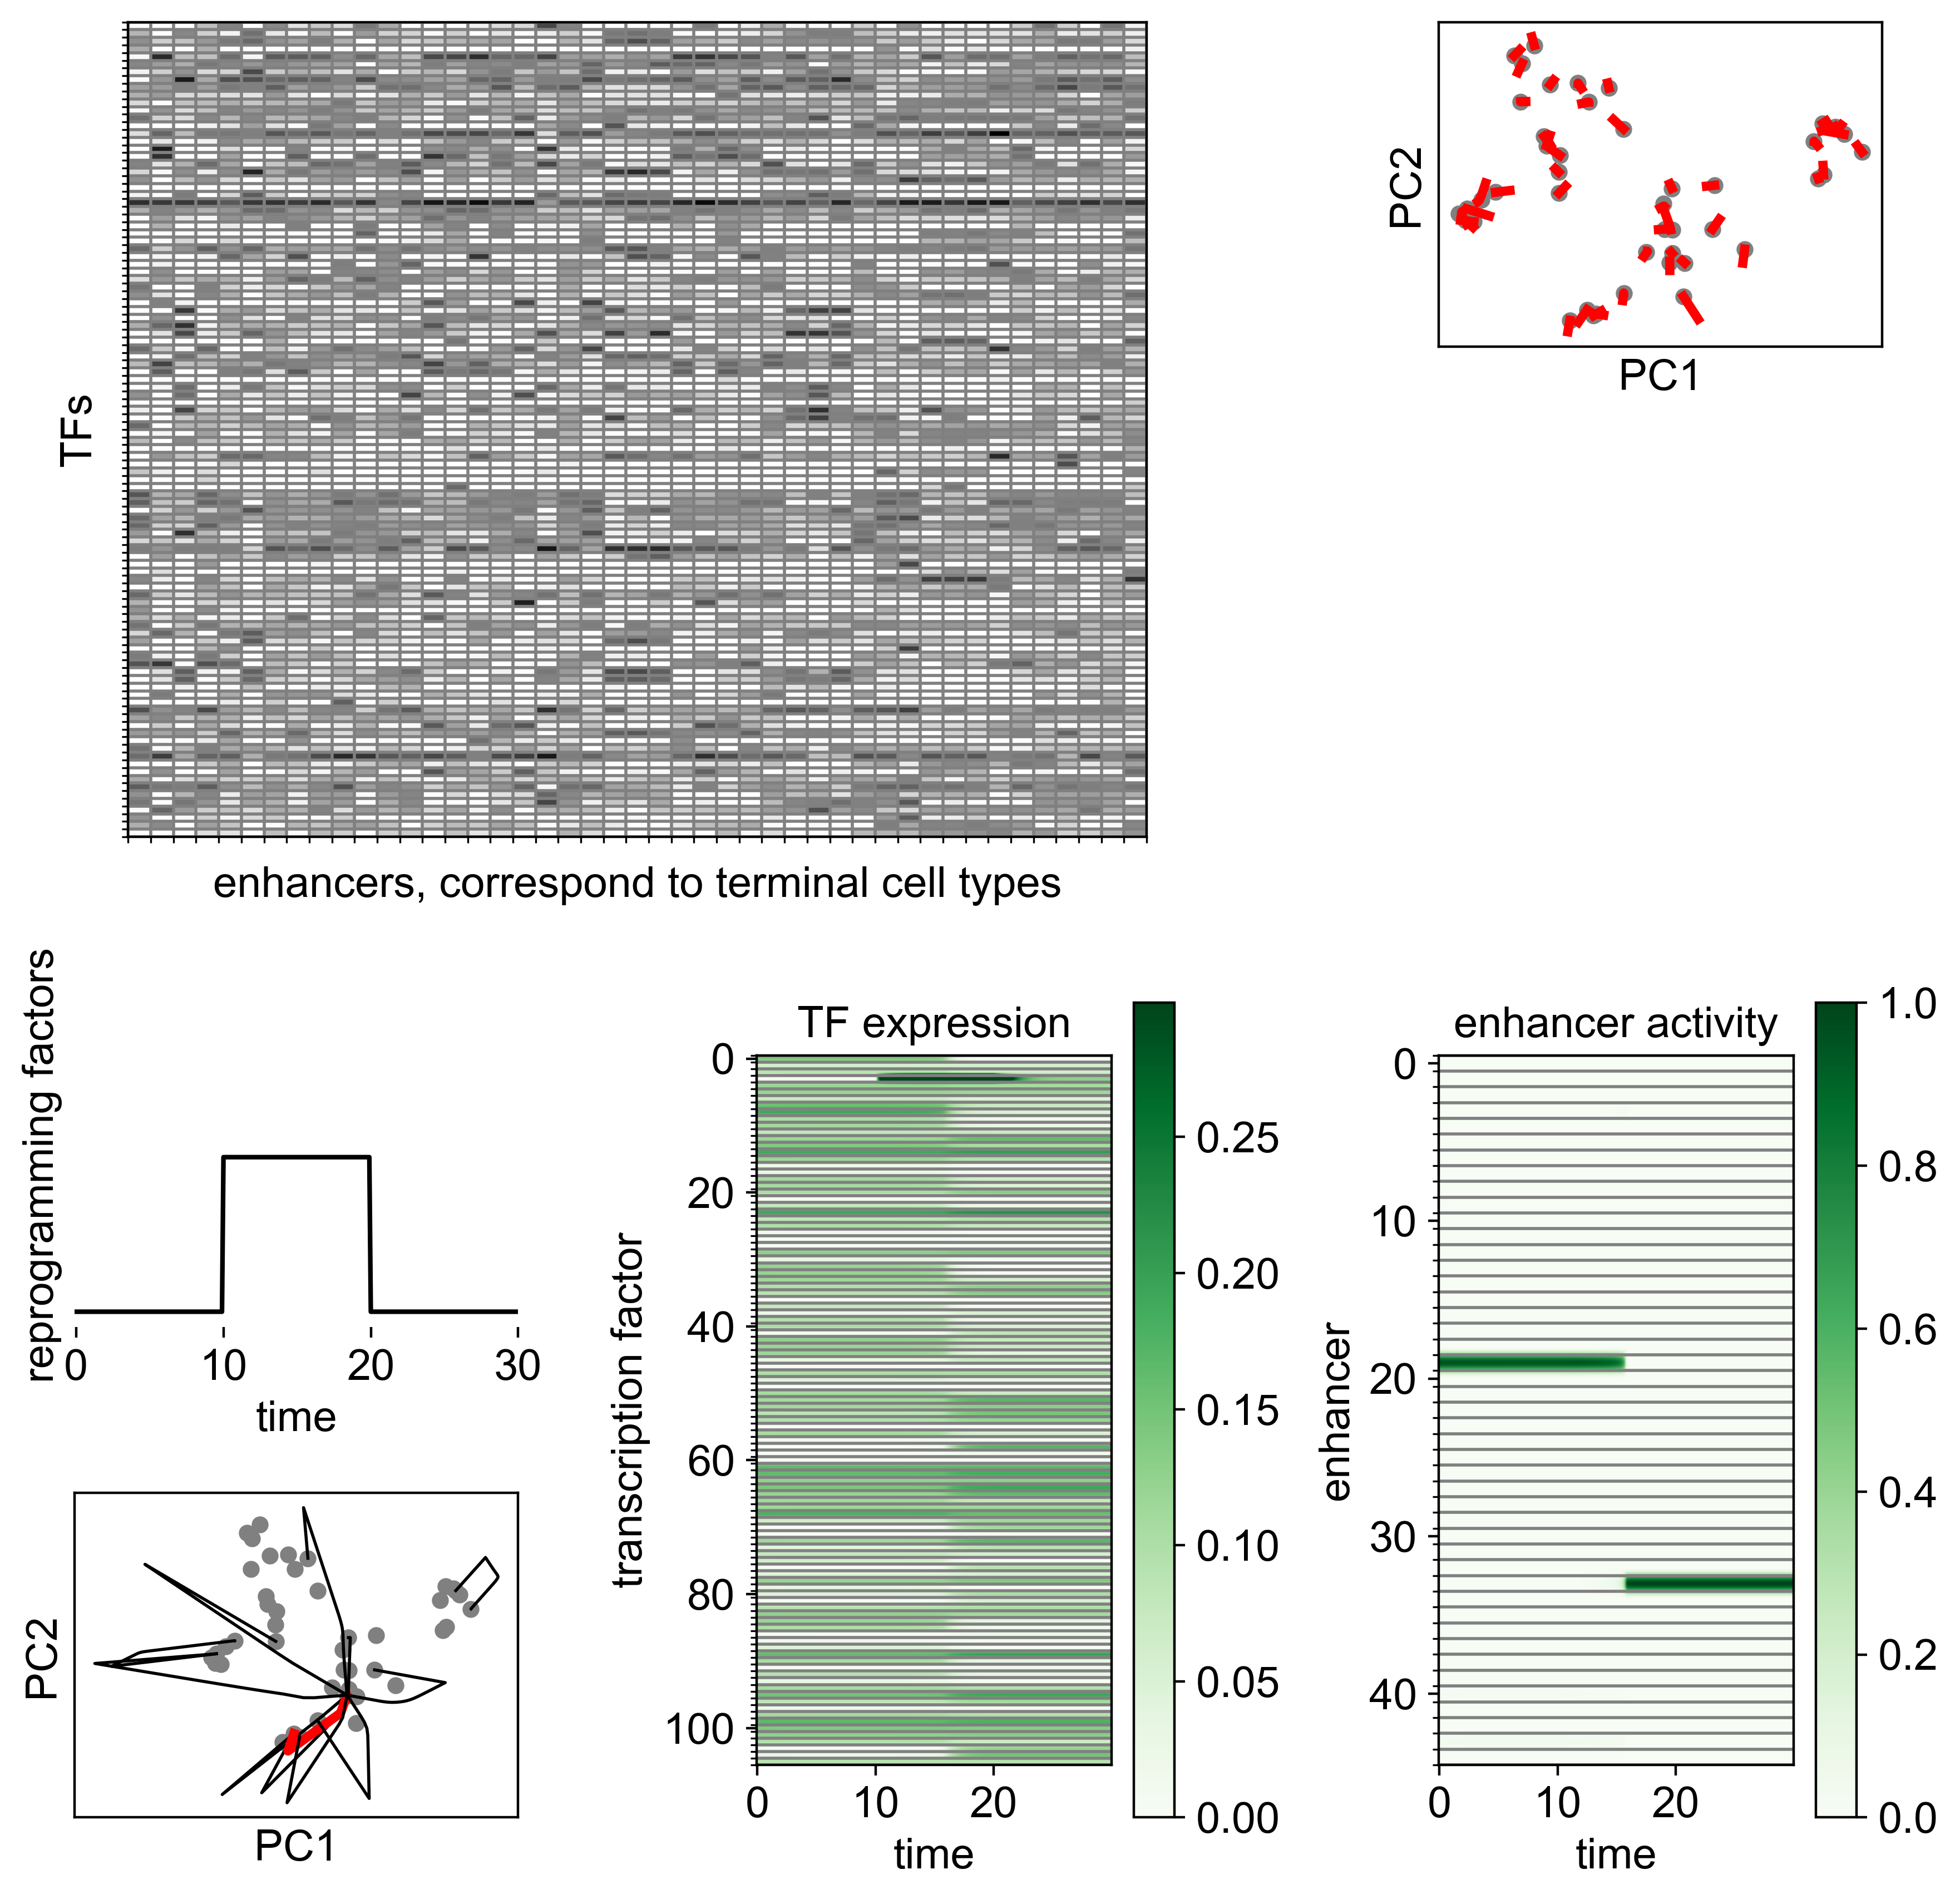

In [27]:
df = preprocess_ctype_patterns(load_ctype_patterns().loc[rel_ctypes])

reprog_idx = 2
enhancer_net = TFProcessStaticBeta(df,np.zeros(df.shape[0]))

fig = plt.figure(figsize=(9,9))
grid = fig.add_gridspec(4, 3)


empty = fig.add_subplot(grid[1,-1])
heatmap_ax = fig.add_subplot(grid[:2,:-1])
idxs=[x.lower() for x in df.index]
Visualizations.plot_patterns(heatmap_ax,enhancer_net.patterns,aspect=.8)
heatmap_ax.set_yticks([])
heatmap_ax.set_xticks([])
heatmap_ax.set_ylabel("TFs")
heatmap_ax.set_xlabel("enhancers, correspond to terminal cell types")
heatmap_ax.set_ylabel("TFs")
heatmap_ax.set_xlabel("enhancers, correspond to terminal cell types")

noised_attractor_ax = fig.add_subplot(grid[0,-1])

pulse_plot = fig.add_subplot(grid[2,0])
pca_ax = fig.add_subplot(grid[3,0 ])
tf_axs = fig.add_subplot(grid[2:,1])
en_axs = fig.add_subplot(grid[2:,2])

empty.set_facecolor('white')
empty.set_axis_off()



resolvers,_,_=enhancer_net.generate_noised_input_trajectories()
Visualizations.plot_pca_trajs(noised_attractor_ax,enhancer_net.patterns,resolvers,range(len(resolvers)))


resolvers=enhancer_net.process_reprogramming_input(reprog_paths,verbose=True)
Visualizations.plot_pca_trajs(pca_ax,enhancer_net.patterns,resolvers,[reprog_idx,])

solver=resolvers[reprog_idx]


pulse_plot.set_facecolor('white')
pulse = lambda t: 1*(t>solver.t.max()/3)*(t<2*solver.t.max()/3)
pulse_plot.plot(solver.t,pulse(solver.t),c='k')
pulse_plot.set_yticks([])
pulse_plot.set_xlabel('time')
pulse_plot.set_ylabel('reprogramming factors')
pulse_plot.set_ylim([-0.1,2])
pulse_plot.set_xlim([-0.1,30])
pulse_plot.set_xticks([0,10,20,30])

pulse_plot.spines['top'].set_visible(False)
pulse_plot.spines['right'].set_visible(False)
pulse_plot.spines['bottom'].set_visible(False)
pulse_plot.spines['left'].set_visible(False)
pulse_plot.grid(None)


Visualizations.plot_enhancer_probs(en_axs,solver,aspect=2,cbar=True,label_annealing=False)
en_axs.set_ylabel("enhancer")
en_axs.set_xlabel("time")
en_axs.set_title("enhancer activity")


Visualizations.plot_tf_levels(tf_axs,solver,aspect=2,cbar=True,label_annealing=False)
tf_axs.set_ylabel("transcription factor")
tf_axs.set_xlabel("time")
tf_axs.set_title("TF expression")

fig.tight_layout()



In [39]:
terminal_lineages = ['B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage',
                     'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage',
                      'Mast Cell Lineage', 'Megakaryocyte Lineage','NK Cell Lineage', 'Neutrophil Lineage',
                      'T Cell Lineage']

tfs = pd.read_csv("../../haemopoiesis/mouse_ensemble_tfs_from_lambertetal_isyes.unique.txt",names=["geneId",]).set_index("geneId")
data = pd.read_csv("../../haemopoiesis/Haemopedia-Mouse-RNASeq_tpm.txt",sep='\t').set_index("geneId")
samples = pd.read_csv("../../haemopoiesis/Haemopedia-Mouse-RNASeq_samples.txt",sep='\t')

data_reduced_merged_lineage = pd.merge(samples.loc[:,["sampleId","cell Type Description","cell_lineage"]],data.T.reset_index().rename(columns={'index': 'sampleId'})).iloc[:,2:].groupby("cell_lineage").mean()
data_reduced_merged_lineage = data_reduced_merged_lineage.drop(["Multi Potential Progenitor","Restricted Potential Progenitor"])

data_reduced_merged = data_reduced_merged_lineage.copy()
data_reduced_merged_log = np.log1p(data_reduced_merged)

# get all variable TFs
data_reduced =data_reduced_merged_log.loc[:,np.intersect1d(tfs.index.values,data_reduced_merged_log.columns)]
data_reduced = data_reduced.loc[:,data_reduced.max()>0]
data_reduced = data_reduced.loc[:,data_reduced.mean()>np.log1p(3)]
data_reduced = data_reduced.loc[:,data_reduced.std()>np.log1p(3)]

data_reduced.index=[x.split(" Lineage")[0] for x in data_reduced.index]


pd.DataFrame(data_reduced.index).to_csv("../../outputs/HEM_Celltypes.csv",header=False, index=False)
pd.DataFrame([mapping[x] for x in data_reduced.columns]).to_csv("../../outputs/HEM_TFs.csv",header=False, index=False)

In [40]:



def annealing_simple_model(en_ax,tf_ax,patterns_ax):
    N = 9 # bits
    K=6 # overall patterns


    df = np.random.normal(size=(K,N))

    df[:,:] = 0
    df[0][:2] = 1
    df[1][1:3] = 1
    df[2][3:5] = 1
    df[3][4:6] = 1
    df[4][6:8] = 1
    df[5][7:9] = 1
    df = pd.DataFrame(df)

    w = np.repeat(0.0,K)
    w[4]=0.05


    enhancer_net = TFProcessAnnealing(df,w,beta_max=8)
    resolver=enhancer_net.annealing(enhancer_net.patterns[0])

    Visualizations.plot_enhancer_probs(en_ax,resolver)
    Visualizations.plot_tf_levels(tf_ax,resolver)
    
    
    Visualizations.plot_patterns(patterns_ax,enhancer_net.patterns)
    

/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_38184/2161544693.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not name in used_names:


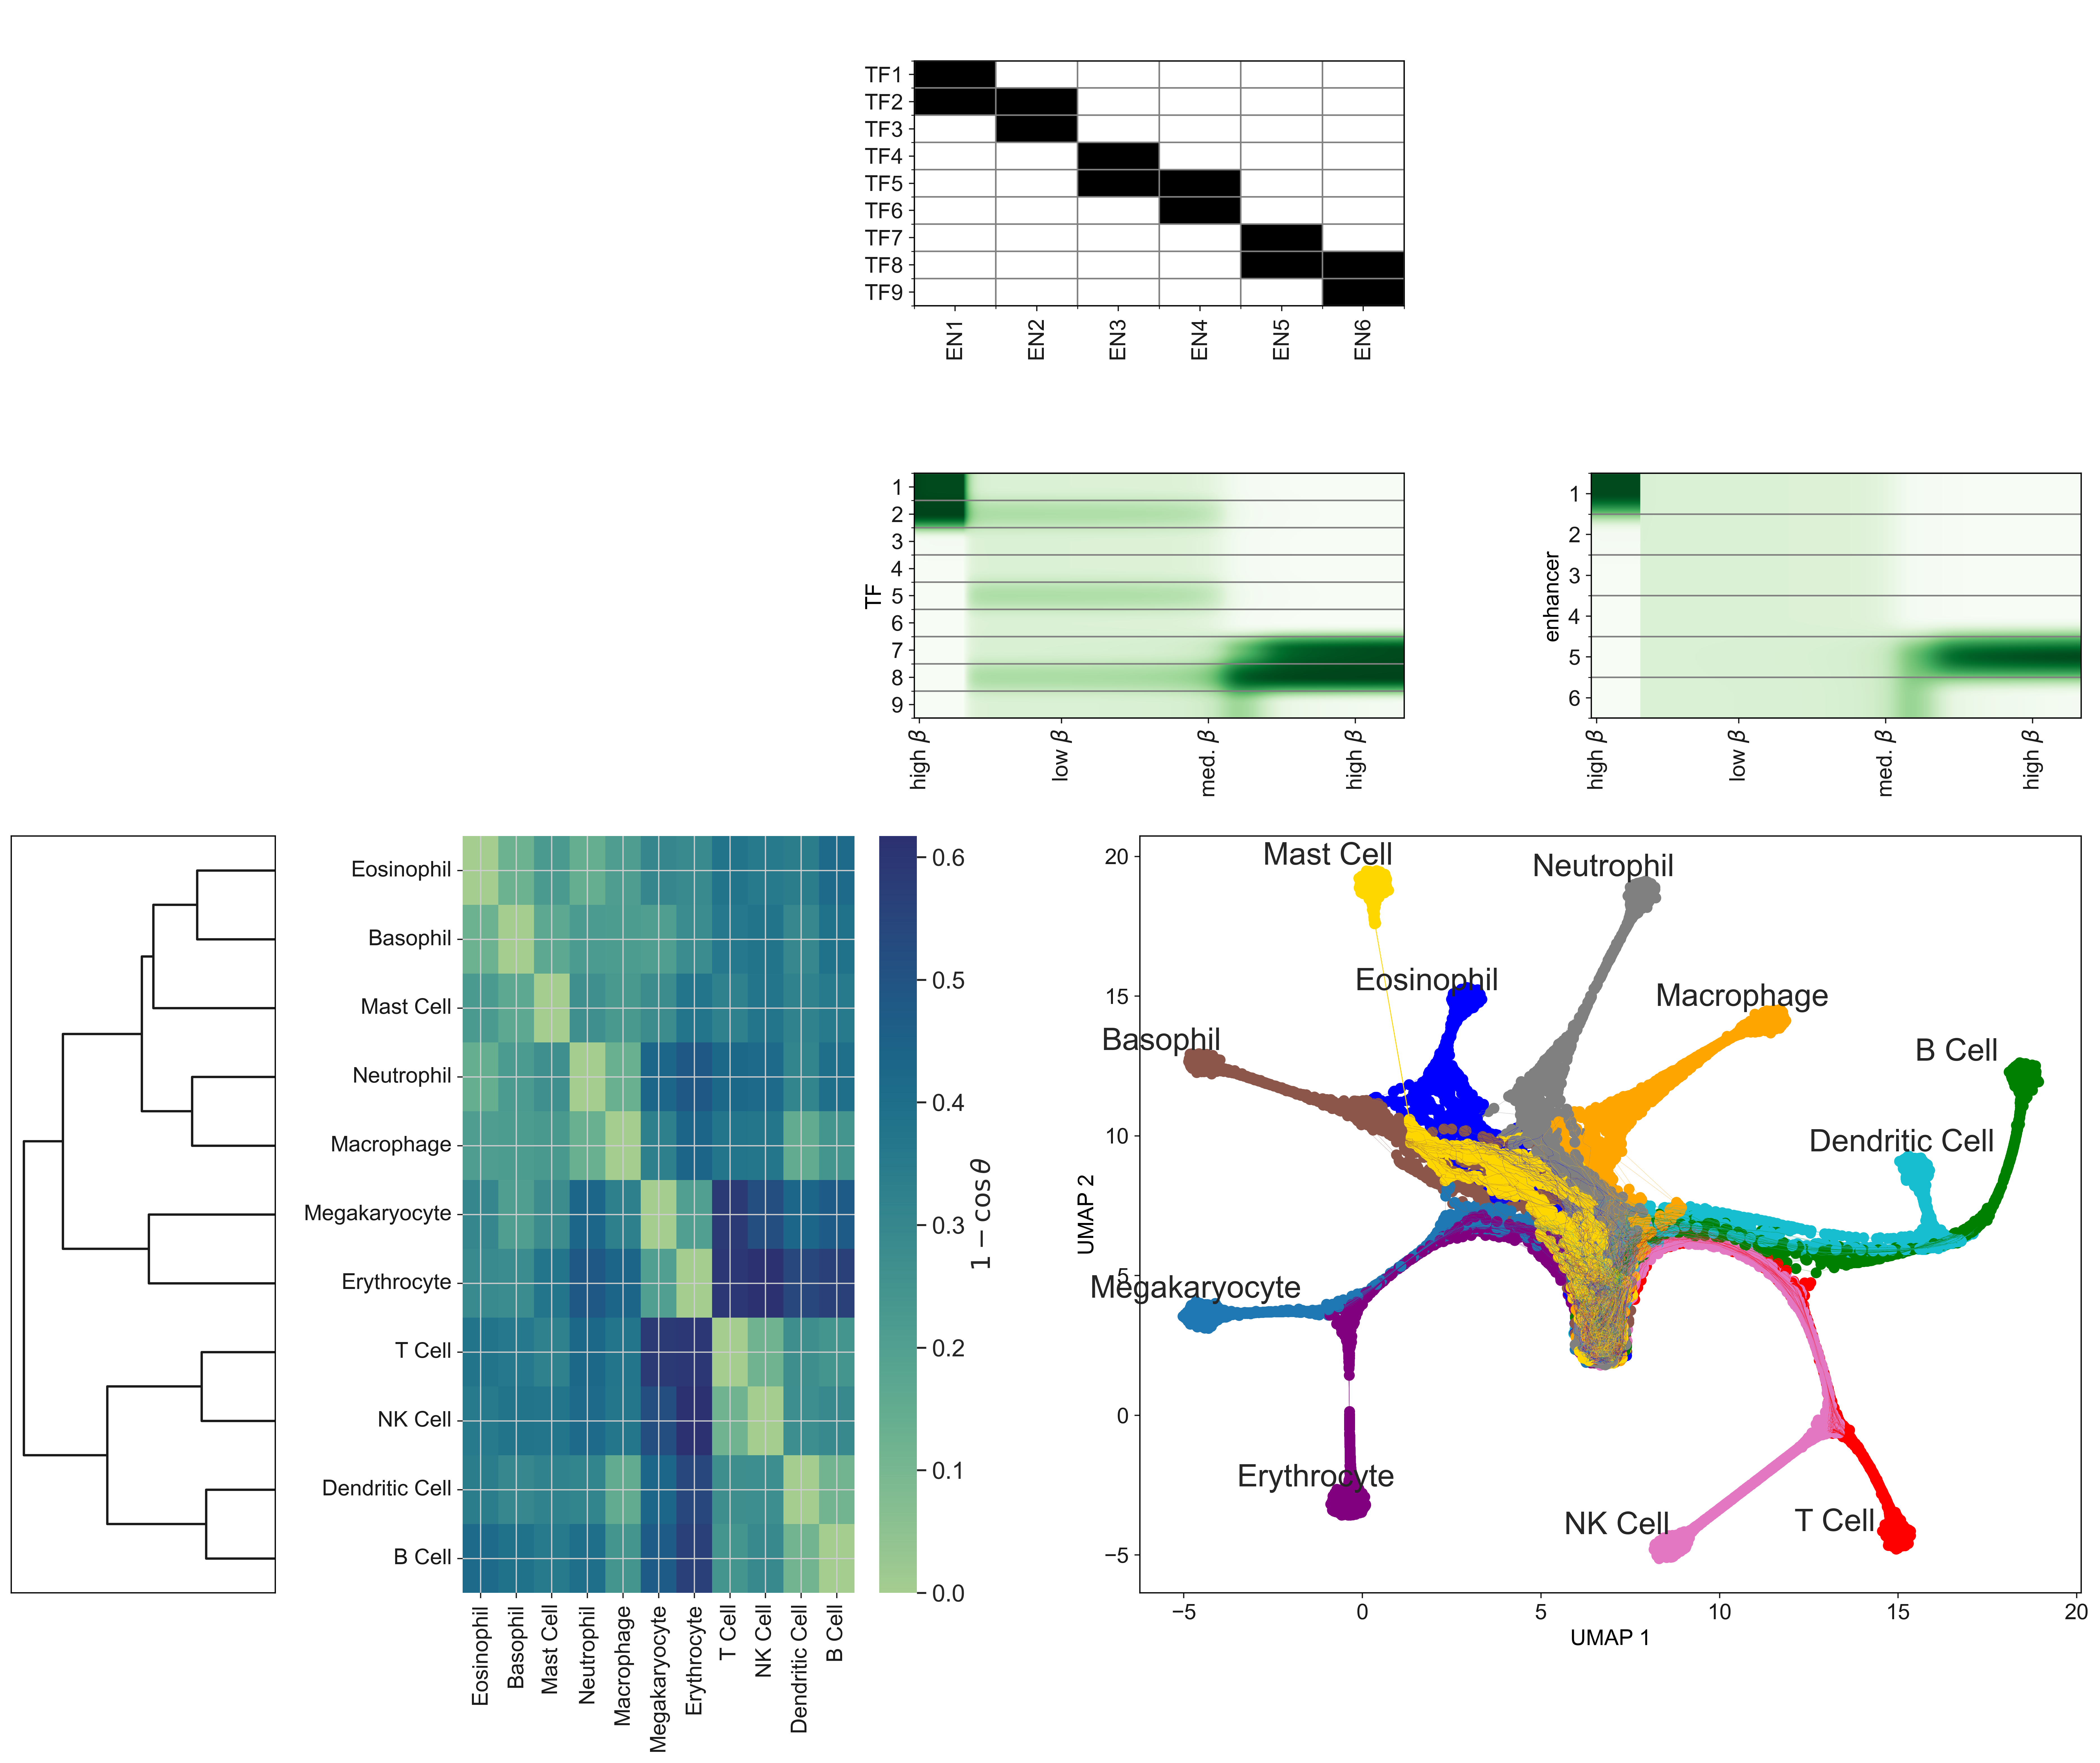

In [41]:
# perform and plot hierarchial clustering
fig = plt.figure(figsize=(19,16))
grid = fig.add_gridspec(8, 10)

empty = fig.add_subplot(grid[:2,:4])
empty.set_facecolor('white')
empty.set_axis_off()


dendro_fig = fig.add_subplot(grid[4:,:2])
heatmap_fig = fig.add_subplot(grid[4:,2:5])
umap_fig = fig.add_subplot(grid[4:,5:])

en_ax = fig.add_subplot(grid[2:4,7:])
tf_ax = fig.add_subplot(grid[2:4,4:7])
patterns_ax = fig.add_subplot(grid[:2,4:7])

annealing_simple_model(en_ax,tf_ax,patterns_ax)

enhancer_net = TFProcessAnnealing(data_reduced,sigma=0.01,beta_max=50,frac_init=0)
Visualizations.plot_heatmap_dendrogram(enhancer_net,heatmap_fig,dendro_fig)

enhancer_net.adj_w_balanced_diff()
resolvers = enhancer_net.produce_differentiation_trajectories()
Visualizations.umap_plot_diff_trajs(umap_fig,resolvers)

fig.tight_layout()



In [42]:
def run_all(genome,axs,beta=50):
    def run_orig():
        x0=np.zeros(genome.N)
        x0[:4]=1/4
        return genome.run_x0(x0,beta=beta)
    def run_ctype_A():
        x0=np.zeros(genome.N)
        x0[:3]=1/3
        return genome.run_x0(x0,beta=beta)

    def run_ctype_B():
        x0=np.zeros(genome.N)
        x0[:2]=1/3
        x0[3]=1/3
        return genome.run_x0(x0,beta=beta)
    
    def run_ctype_C():
        x0=np.zeros(genome.N)
        x0[2]=0.5
        x0[4]=0.5
        return genome.run_x0(x0,beta=beta)

    Visualizations.plot_tf_levels(axs[0],run_orig(),aspect=1.5,vmax=0.5)
    axs[0].set_title("ancestral cell")
    Visualizations.plot_tf_levels(axs[1],run_ctype_A(),aspect=1.5,vmax=0.5)
    axs[1].set_title("sister cell A")
    Visualizations.plot_tf_levels(axs[2],run_ctype_B(),aspect=1.5,vmax=0.5)
    axs[2].set_title("sister cell B")
    Visualizations.plot_tf_levels(axs[3],run_ctype_C(),aspect=1.5,vmax=0.5)
    axs[3].set_title("other cell type")
    for ax in axs:
        ax.set_xticks([])
        ax.set_xlabel("time")
    


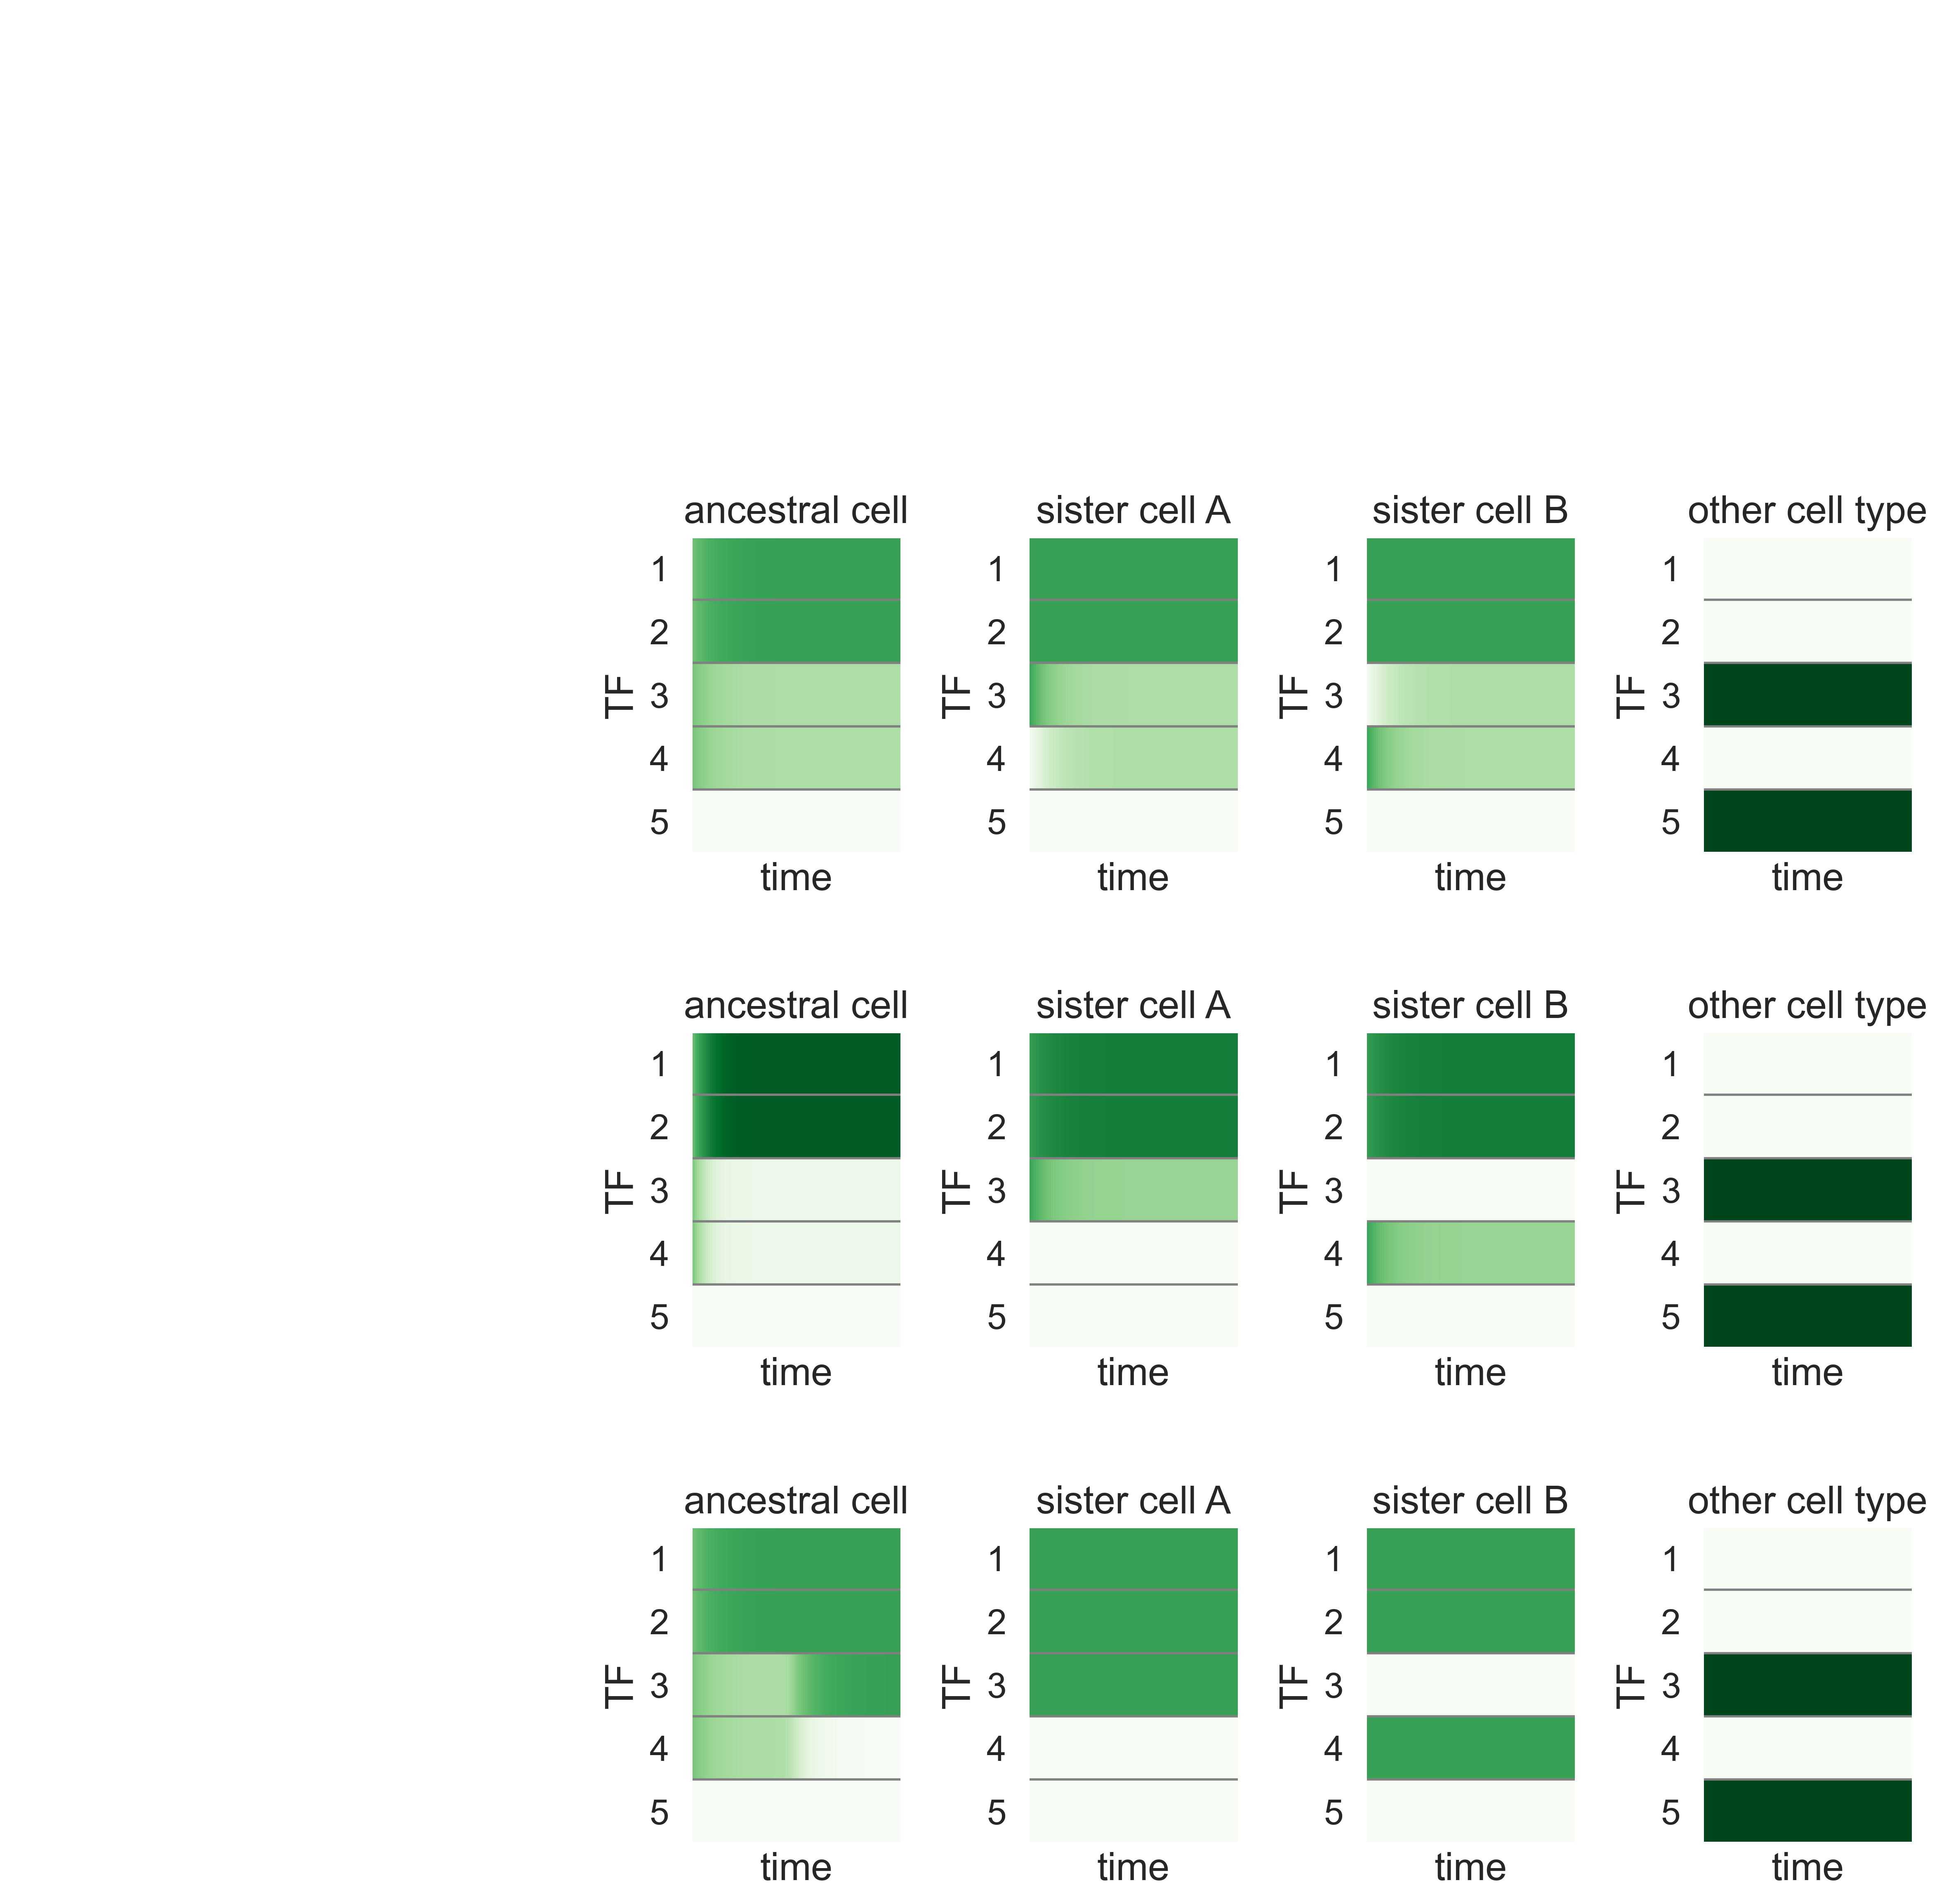

In [44]:
enhancer_binding_profiles =   {"EN0" : [0,1,2,3], "EN1" : [0,], "EN2" : [2,], "EN3" : [2,4]}
enhancer_locations = {"EN0" : [0,0,1,1,2,3], "EN1" : [0,],"EN2" : [2,], "EN3" : [2,4]}

genome = GenomeFromEnAssociations(enhancer_binding_profiles,enhancer_locations)


fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(4, 6)


empty=fig.add_subplot(grid[:,0])
empty.set_facecolor('white')
empty.set_axis_off()

run_all(genome,[fig.add_subplot(grid[1,j]) for j in range(2,6)])
genome.xi_mat[5][2]=0
genome.xi_mat[4][3]=0
run_all(genome,[fig.add_subplot(grid[2,j]) for j in range(2,6)])
genome.xi_mat[0][2]=0
genome.xi_mat[1][3]=0
genome.xi_mat[2][2]=0
genome.xi_mat[3][3]=0
run_all(genome,[fig.add_subplot(grid[3,j]) for j in range(2,6)])
fig.tight_layout()

